# Online Reviews Analysis - NLP - (Part-1)

## Walmart online reviews analysis

Online reviews are important for both seller and customer to evaluate a product. however, it is time-consuming to go through all product reviews to get valuable insights. This analysis will go through two methods that can be used to analyze customers' reviews. I used a Walmart [reviews-scrapper](https://github.com/AnasBuhayh/reviews-scrapper) script to collect the reviews from [Walmart.com](https://www.walmart.com/). The script is available in my repo. This analysis will contain two methods. The first method is to collect reviews based on Term Frequency known as [TF](https://www.opinosis-analytics.com/knowledge-base/term-frequency-explained/#.X9ZqothKiHs). This is used to get reviews that are more representative of the total reviews. The second method is to apply sentiment analysis for sentences based on Term Frequency - Inverse Document Frequency is known as [TF-IDF](https://monkeylearn.com/blog/what-is-tf-idf/#:~:text=TF%2DIDF%20is%20a%20statistical,across%20a%20set%20of%20documents.) to get a feel of what do people feel about a specific feature.

The goal of this article is to provide the knowledge to implement the analysis and providing a few chunks of code that might be helpful for some people. required knowledge of python and natural language processing is preferred to get the most of this article.

## Importing data

Let's start with importing the data collected by the [reviews-scrapper](https://github.com/AnasBuhayh/reviews-scrapper). I will drop the product name form the dataset for privacy. We can also print out some summaries to see what do we need to work on.

In [362]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display

df = pd.read_csv('product_reviews.csv').drop(columns=['Product'], axis=1)

let's get to know our data before doing any analysis by printing the head of the data

In [363]:
display(df.head())

,Date,Title,Review_Text,Rating
0,"July 30, 2020",none,Only problem. This model cannot be synced to X...,5.0
1,"August 19, 2020",Great TV for the price! No complaints!,"Haven't been using this TV for too long, but s...",5.0
2,"April 6, 2020",Great price great tv. I made a great choice,I purchased my tv a few weeks ago. It was deli...,5.0
3,"August 24, 2020",great value for all primary features,most cost-effective TV on the market. I have b...,5.0
4,"November 21, 2020",Decent first leap into the 4k world,So I basically got this to support my xbox ser...,5.0


As we can see from the table head, the data has 4 columns. We are only interested in the review and rating. Now we know how our data looks like, let's see what are the data types of our columns and if we have any missing values.

In [364]:
display(df.info())
display(df.isna().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3660 entries, 0 to 3659
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Date         3660 non-null   object 
 1   Title        3660 non-null   object 
 2   Review_Text  3660 non-null   object 
 3   Rating       3660 non-null   float64
dtypes: float64(1), object(3)
memory usage: 114.5+ KB


None

Date           0
Title          0
Review_Text    0
Rating         0
dtype: int64

No missing values, looks like we are good! are we thoough? let's check

In [365]:
print("Missing Titles: ", len(df[df['Title'] == 'none']))
print("Missing Reviews: ",len(df[df['Review_Text'] == 'none']))

Missing Titles:  1829
Missing Reviews:  1245


The [reviews-scrapper](https://github.com/AnasBuhayh/reviews-scrapper) returns the empty values on Walmart's website as 'none'. so please keep that in mind if you are planning to use it.

The goal of this analysis is to analyze review bodies and not titles as the body usually have more valuable content. therefore, let's remove the reviews that contain the word 'none'.

In [366]:
df = df[df['Review_Text'] != 'none']

## The Analysis

### Summarizing Reviews

The first method we will use is summarizing the reviews. The question is, how can we get the most valuable reviews? and what makes a review more valuable than the other?

to answer the questions, we will use the term frequency to summarize the reviews and collect the most relevant ones. This method is about calculating the ranking of each word based on how many times it shows up in the text. Every review ranking would be the sum of the words rankings that it contains. We will create a function that will receive a collection of reviews and return the ones that have the highest ranking.

In [367]:
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.probability import FreqDist
from nltk.corpus import stopwords
import collections
from heapq import nlargest 
from string import punctuation

def summarize(reviews, n):
    
    text = ' '.join(reviews)
    corpus = word_tokenize(text.lower()) # creating a bag of words
    _stopwords = set(stopwords.words('english') + list(punctuation))

    corpus = [word for word in corpus if word not in _stopwords] # stripping stopwords
    freq = FreqDist(corpus) # frequency distribution for all the non-stopwords

    ranking = collections.defaultdict(int) #to avoid KeyError

    # now let's break down how this loop works
    for i, sent in enumerate(reviews): # loop through the reviews we have
        for w in word_tokenize(sent.lower()): # loop through the words in the reviews
            if w in freq: # if the word in our frquenct object
                ranking[i] += freq[w] # if the word to the review, add the rank 

    reviews_idx = nlargest(n, ranking, key=ranking.get) # get the n reviews with the highest ranking
    return [reviews[j] for j in sorted(reviews_idx)]

Now we call the function and get the review is the highest-ranking

In [368]:
reviews = df[df['Rating'] == 5]['Review_Text'].tolist()
summarize(reviews, 1)

["This is my first experience with a smart tv. Over all I really like it. It is a good screen size, has good picture quality, and has excellent sound. Some things you need to know- The front of the box shows 2 remotes. You only get one remote. It is the Roku remote. The big draw back here is there are no numbers on the remote so you can't just punch in a channel number. You have to scroll thru all the channels. Not a big deal if you have antenna tv and only have 30 or so channels. But even then it is aggravating. So if you have satellite and have over 300 channels it is going to be aggravating when you are on channel 23 and need to scroll to 240. Another thing I do not like is the TV picks your favorite channels for you. Those channels are then put separate from the other channels. So if you are on channel 27 and want to go to 29 and it has picked 29 as a favorite for you (it chooses them by how often you watch them) then when you scroll up through the channels it goes 27, 28, 30. Numb

## Sentiment  Analysis

Now let's say that you want to know how people feel about specific features in your product, the sound of the TV for example. to do this, we can calculate the sentiment of the sentence where the word "sound" is mentioned. Then associate the sentiment value to the word "sound". Then we can calculate the average of the associated values.

But What if you want to get the most mentioned features in the reviews without going through them one by one to find the most frequent features? for that, we can use what is known as [TF-IDF](https://programminghistorian.org/en/lessons/analyzing-documents-with-tfidf). In simple words, Both TF (term frequency) and IDF (inverse document frequency) measures how many times does a word shows up in a document. However, the TF counts how many times does the word occurs in the document, and the IDF measures how common or rare the word is in the document. Where for IDF, the closer the word's value to 0 the more common it is. we multiply the result of TF by the IDF to come up with the weight of importance for each word.

In [369]:
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.tag import pos_tag
import nltk
import re

corpus = df['Review_Text'].tolist()
corpus = ' '.join(corpus).lower()
corpus = corpus.split() # creating a bag of words

# keeping the nouns only 
tags = nltk.pos_tag(corpus)
corpus = [word for word,pos in tags if (pos == 'NN' or pos == 'NNP' or pos == 'NNS' or pos == 'NNPS')]

vectorizer = TfidfVectorizer(max_df=.65, min_df=1, stop_words='english', use_idf=True, norm=None, token_pattern=u'[a-zA-Z]{3,}')
doc_term_matrix = vectorizer.fit_transform(corpus)

tf_idf = pd.DataFrame(doc_term_matrix.toarray(), columns=vectorizer.get_feature_names())

We can display the words by their TF-IDF weight to see what are the most valuable nouns that we can use for our sentiment analysis

In [370]:
tf_idf_rank = tf_idf.mean().sort_values(ascending=False).head(20)
tf_idf_rank = tf_idf_rank.to_frame().reset_index()
tf_idf_rank = tf_idf_rank.rename(columns={"index": "word", 0:"weight"})
display(tf_idf_rank)

,word,weight
0,picture,0.170737
1,price,0.109277
2,roku,0.096776
3,quality,0.090247
4,sound,0.080850
5,tcl,0.073934
6,screen,0.060982
7,remote,0.049394
8,time,0.039147
9,year,0.038732


Let's drop the unwanted words from the list and plot our data for better visualization

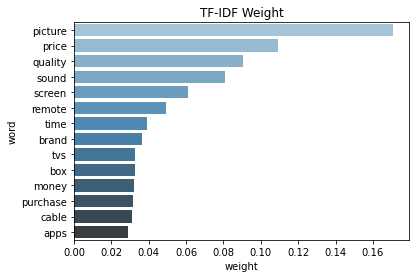

In [371]:
import seaborn as sns

unwanted_words = ['roku','tcl','year','years','room','months']
tf_idf_rank = tf_idf_rank[~tf_idf_rank['word'].isin(unwanted_words)]
tf_idf_rank.reset_index(drop=True)

ax = sns.barplot(x="weight", y="word", data=tf_idf_rank, palette="Blues_d").set_title('TF-IDF Weight')

The bar chart represents the weight of the words using TF-IDF. According to our analysis, the word picture has the highest weight or TF-IDF score. 

now we have the words with the highest weights, we can calculate the sentenses where these words are mentioned. We will use [TextBlob](https://textblob.readthedocs.io/en/dev/) to calculate the sentiment . 

> According to the documentation "The polarity score is a float within the range -1.0, 1.0. The subjectivity is a float within the range 0.0, 1.0 where 0.0 is very objective and 1.0 is very subjective."

I will make a (+1) shift for the polarity so we can end up with a value between 0 and 2. This can help with calculating the average 

In [372]:
top_ranked_words = tf_idf_rank['word'].tolist()

In [373]:
#first let's add a sentement column to our dataframe
# 1 get the review
# 2 get the sentense that has the word you are looking for
# 3 calculate the sintement for that sentence
# 4 add the value of the sentement to a list
from textblob import TextBlob

di = dict()
for i in range(0, len(df)):
    sents = df.iloc[i]['Review_Text'].split('.')
    #loop through the words in the top_ranked_words
    for word in top_ranked_words:
        # check if the word exist in any of the sentences
        for sent in sents:
            if word in sent:
                #count setement value for each sentense. +1 is used to change the scale so we can calculate the mean
                di[word] = di.get(word, []) + [TextBlob(sent).sentiment.polarity + 1]

Finally, calculating the average of the sentiment values

In [374]:
from statistics import mean

for word in di.keys():
    di[word] = mean(di[word])

time to plot

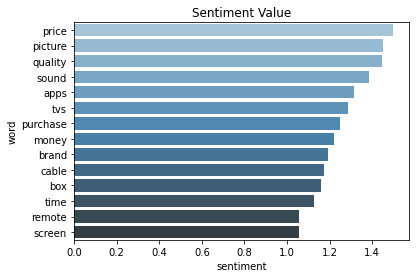

In [375]:
sentiment_values = pd.DataFrame.from_dict(di, orient='index', columns=['sentiment'])
sentiment_values = sentiment_values.reset_index().rename(columns={"index": "word"}).sort_values(by='sentiment', ascending=False)

ax2 = sns.barplot(x="sentiment", y="word", data=sentiment_values, palette="Blues_d").set_title('Sentiment Value')

With this graph we can see the degree of how much are peaple satisfied with each of the features. 

Thank you for reading, and I hope that you found some things that can be useful to you. Please reach out if you have any questions or suggestions. 
I will see you in part two, where we will implement prediction models and see if we can find any patterns in our data.